In [27]:
#Import statments
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix

In [28]:
#Use this to create dataloaders

#Img Transforms
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder('/kaggle/input/rice-seeds/bw-rice-imgs', transform=data_transform)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 20000, replace=False))

train_dataset, val_dataset = torch.utils.data.random_split(dataset_subset, [0.8,0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # i = 250 * 250 * 3
        self.conv1 = nn.Conv2d(3, 32, 50, 5) # o = (250-50)/5 + 1 = 41
        self.pool = nn.MaxPool2d(2, 2) # o = 20
        self.conv2 = nn.Conv2d(32, 64, 5) #o1 = (20 - 5) + 1 = 16
        # Pool: o = 8
        #self.fc1 = nn.Linear(8 * 8 * 64, 400) 
        self.fc1 = nn.Linear(4096, 400)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(400, 6)

    def forward(self, x):
        x = normalize(x, p=2.0)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [30]:
#accuracy function
def get_accuracy(model, data_loader):
    start = timer()
    #print("Getting accuracy")
    correct = 0
    total = 0
    for imgs, labels in data_loader:
                  
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #img_fix = imgs.transpose(1,3)
        #img_fix = imgs.permute(0,3,1,2)
        
        #img_fix = torch.reshape(imgs,(1,3,250,250))
        img_fix = imgs
        
        output = model(img_fix)
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        #print(pred,labels.view_as(pred))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    end = timer()
    #print("get_accuracy took: " + str(end-start))
    return correct / total
print("done")

done


In [31]:
def train(model, train_loader, val_loader, batch_size=100, num_epochs=1 , print_stat = 1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    counter = 0 #number of batches
    for epoch in range(num_epochs):
        start = timer()
        #print("epoch: " + str(epoch + 1))
        epoch_loss = 0
        for imgs, labels in iter(train_loader):
            counter += 1
            #print("Batch Number: " + str(counter))

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            img_fix = imgs
            out = model(img_fix)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            epoch_loss += loss.detach().cpu().numpy()

            # save the current training information
        iters.append(n)
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        losses.append(epoch_loss)
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} Val acc: {} Epoch loss: {}").format(
                    epoch + 1,
                    train_acc[epoch],
                    val_acc[epoch],
                    losses[epoch]))
        n += 1
        # save the state of the model and optimizer
        state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, 'cnn_model_checkpoint.pt')
        end = timer()
        print("Epoch " + str(epoch+1) + " took: " + str(end-start))

    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(iters, losses.copy(), label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.9408125 Val acc: 0.93875 Epoch loss: 64.50911181420088
Epoch 1 took: 198.2181979420002
Epoch 2: Train acc: 0.9278125 Val acc: 0.92725 Epoch loss: 29.08836181089282
Epoch 2 took: 128.0919702129995
Epoch 3: Train acc: 0.94525 Val acc: 0.94775 Epoch loss: 24.278132177889347
Epoch 3 took: 130.71678804699968
Epoch 4: Train acc: 0.9546875 Val acc: 0.9545 Epoch loss: 21.249279711395502
Epoch 4 took: 128.61706088100073
Epoch 5: Train acc: 0.9676875 Val acc: 0.967 Epoch loss: 18.6785351857543
Epoch 5 took: 128.08837095499985
Epoch 6: Train acc: 0.955125 Val acc: 0.956 Epoch loss: 17.686565646901727
Epoch 6 took: 128.02147837199936
Epoch 7: Train acc: 0.973625 Val acc: 0.97325 Epoch loss: 15.54512001760304
Epoch 7 took: 128.132250527
Epoch 8: Train acc: 0.976375 Val acc: 0.97275 Epoch loss: 14.262465694919229
Epoch 8 took: 126.70634912300011
Epoch 9: Train acc: 0.9618125 Val acc: 0.9625 Epoch loss: 12.94123435113579
Epoch 9 took: 126.

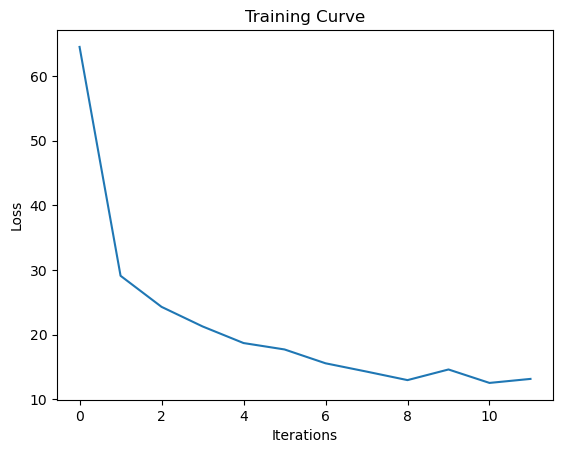

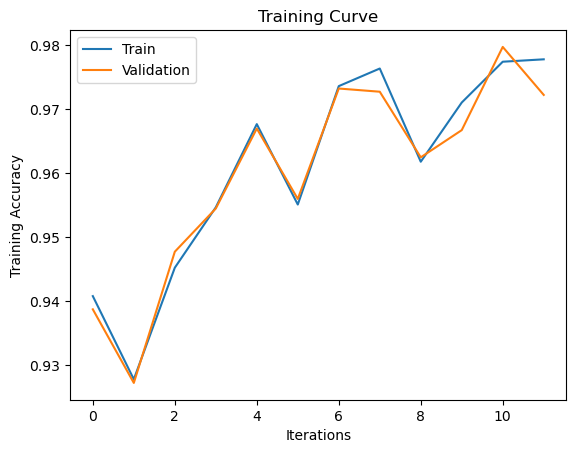

Final Training Accuracy: 0.9778125
Final Validation Accuracy: 0.97225


In [32]:
# Create model, run
riceClassifier = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  riceClassifier.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(riceClassifier, train_loader, val_loader, batch_size=100, num_epochs=12, print_stat=1)

In [33]:
def get_test_accuracy(model, data_loader):
    
    class0wrong = 0
    class1wrong = 0
    class3wrong = 0
    totalCorrect = 0
    
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in data_loader:

            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            output = model(imgs)
            
            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]

            
            if(pred.item() != labels.item()):
                if(labels.item() == 0):
                    class0wrong+=1
                elif(labels.item() == 1):
                    class1wrong+=1
                elif(labels.item() == 3):
                    class3wrong+=1
                else:
                    print(str(labels.item()) + "  " + str(pred.item()))
            else:
                totalCorrect+=1
            
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
    
    print(totalCorrect/total)
    print(class0wrong)
    print(class1wrong)
    print(class3wrong)

    
    return correct / total

In [42]:
#test accuracy on test set
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(saturation=0.8, brightness=2.77, contrast=5.8, hue=0),
    transforms.ToTensor()
])

testDataset = torchvision.datasets.ImageFolder('/kaggle/input/rgb-five-rice-type', transform=test_transform)

from collections import Counter
from torchvision.datasets import ImageFolder

# Count the number of samples for each class
class_counts = Counter(testDataset.targets)
# Print the counts
print(class_counts)

finalTest_loader = torch.utils.data.DataLoader(testDataset, batch_size=1, shuffle=True)

get_test_accuracy(riceClassifier, finalTest_loader)

Counter({0: 45, 1: 45, 3: 45, 2: 1, 4: 1})
4  0
0.40875912408759124
17
20
43


0.40875912408759124

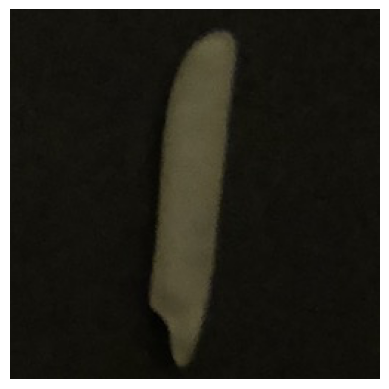

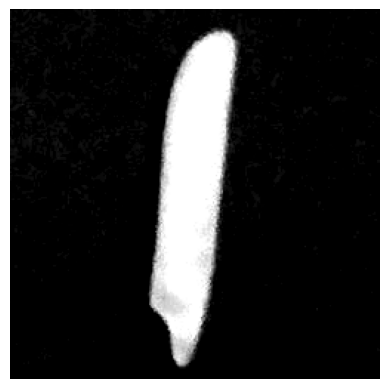

tensor(1, device='cuda:0')


In [38]:
# Define transforms to process data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(saturation=0.8, brightness=2.77, contrast=5.8, hue=0),
    transforms.ToTensor()
])

# Show raw image
image = Image.open('/kaggle/input/rgb-five-rice-type/1/basmati1 copy 4.JPG')
plt.imshow(image)
plt.axis('off')
plt.show()

# Apply transforms
image = transform(image)

# Convert image to numpy array
image_np = image.numpy().transpose(1, 2, 0)

# Show processed image
plt.imshow(image_np)
plt.axis('off')
plt.show()

output = riceClassifier(image.cuda())

# Get the output of the model
prediction = torch.argmax(output)

# Print the prediction
print(prediction)
